In [31]:
# Auto reload
%load_ext autoreload
%autoreload 2

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Add this project to the path
import os; import sys; currDir = os.path.dirname(os.path.realpath("__file__"))
rootDir = os.path.abspath(os.path.join(currDir, '..')); sys.path.insert(1, rootDir + '/src')

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Options
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 16
pd.set_option('display.max_columns', None)

# Peek at the data
df = pd.read_csv("../data/raw/bank-additional-full.csv", sep=";")
df.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# What is the Problem?

## Informal

The classification goal is to predict if the client will make a particular cash investment with the bank.

## Formal

A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E

- E - A list of clients with attributes about the clients
- T - Classify if a client will make a particular cash investment with the bank
- P - Kappa (normalized accuracy), the number of clients correctly classified whether they will make this investment (yes/no).


## Assumptions
- Day of the week could be important, probably want to try different transforms
- Month may be useful, certain months might be better.  I don't have a guess for which ones.
- A housing loan will be a positively correlated with the target.  These people have relied on the bank before for loans, and they often have good income.  Most people probably have a house, so I'm interested in which people do or do not have house loans.
- A personal loan indicates that this person probably doesn't have a large amount saved, but they may be looking to gain passive income to pay off debt
- For those with credit in default, they may be less willing to invest because they have other commitments to pay off before investing.  They also might be looking to make cash quickly to remove the stress of a default, so earning passive income may interest them.  It could go either way.
- marital status should have a large affect because I think finances are often different for each marital status group.
- The job title will be a great attribute indicating disposable income.  Might want to estimate the salary of each job as well to have an additional attribute combined across jobs.
- Age should be a good attribute for disposable income to invest.
- Duration should be discarded
- The quarterly indicators will have little effect
- Contact communication type probably doesn't matter
- Previous marketing campaign will be rarely used but useful when there is history.  If successful in the past, it will be more likely to be successful and likewise, failures in the past will more likely be failures again.  Also a success in the past may also lead to a failure in the future if they already have an investment with them.
- Previous number of contacts performed could be useful, there might be a middling number that does best.
- Days since last contacted from a previous campaign could be useful, will have to consider dealing with missing values.  A middling number might do best.

## Why Does It Need to Be Solved?

### Motivation

We can only reach out to so many people, so we want to reach out to those who are most likely to say yes to our investment opportunity.

### Solution Benefits

This solution would be a large improvement over unprioritized calls to clients.

### How the Solution Will Be Used

The model will rank the predictions and we give these rankings to our sales people to reach out the the right people.

## Solving the Problem Manually

The problem would be solved manually by calling those with a favorable age, credit history, and education.  Also people with a high paying job may have a higher priority.

# Prepare Data

## Select Data

**What data do you have available?**

The work has been done for us, we should include all of the data from the bank-additional-full file.  This file includes all the attributes and rows available.  

**What data is not available that you wish was available?**

It would have been nice to have the salary of each client.  Any data that indicates that a user is interested in the investment would help.  Implicityly or explicitly collected data would be helpful to cluster clients together to find those similar to those interested in past campaigns.  Active use on the website or app shows interest and would help towards prioritizing leads.  If credit card data can be used ethically it would help.

**What data should be excluded?**

The duration column is a data leak and should be excluded.

# Preprocess Data

## Formatting

I'll keep the data in CSV format.

## Cleaning

**Removing Attributes**

In [32]:
df = df.drop(["duration"], axis=1)

**Missing Values**

In [33]:
# Find missing values
any_missing = df.isna().any(); missing_attributes = list(any_missing[any_missing == True].index)
df['y'] = df['y'].apply(lambda x: 1 if x == "yes" else 0)
print("Missing values are in these attributes:", missing_attributes)


Missing values are in these attributes: []


## Sampling

In [34]:
%autoreload 2
from data.make_dataset import *

# Split data
train, sample_train, test = split_data(df=df)


['DataFrame shapes:', (32950, 20), (8238, 20), (8238, 20), (41188, 20)]
['Class Balance per DataFrame:',
 [0.8873458288821987, 0.11265417111780131],
 [0.8800679776644816, 0.11993202233551833],
 [0.889165402124431, 0.11083459787556904],
 [0.8811604758436514, 0.11883952415634863]]


# Transform Data

## Scaling

In [35]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
11588,27,admin.,single,university.degree,no,no,no,telephone,jun,fri,2,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
27308,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
28936,34,management,married,university.degree,no,yes,no,cellular,apr,fri,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
36313,31,services,single,university.degree,no,yes,no,telephone,jun,mon,2,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0
27761,34,technician,single,professional.course,no,yes,yes,cellular,mar,fri,1,999,0,nonexistent,-1.8,92.843,-50.0,1.726,5099.1,0


## Histograms

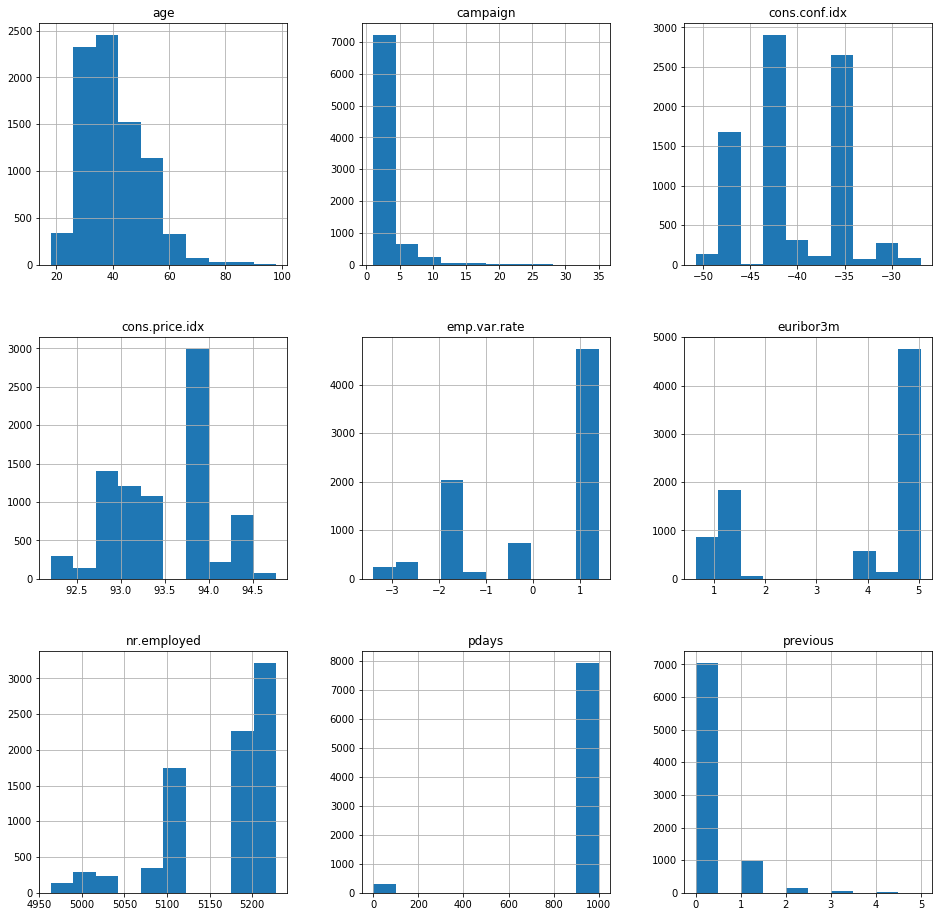

In [36]:
%autoreload 2
from visualization.visualize import *

# Histograms
histograms_for_nonbinary_columns(sample_train=sample_train)


                                            Plots for age                                             


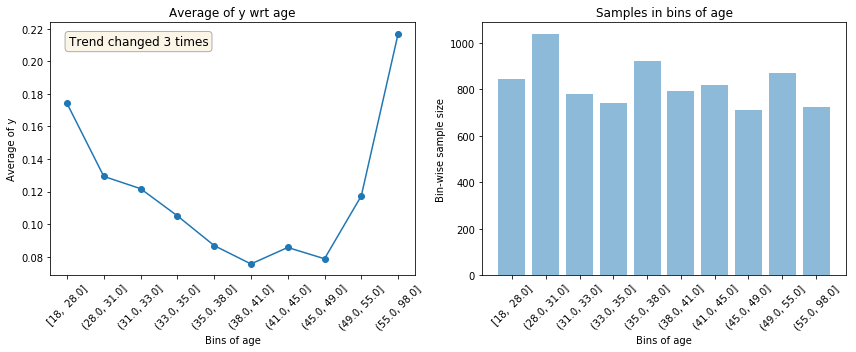

--------------------------------------------------------------------------------------------------------------


job is categorical. Categorical features not supported yet.
marital is categorical. Categorical features not supported yet.
education is categorical. Categorical features not supported yet.
default is categorical. Categorical features not supported yet.
housing is categorical. Categorical features not supported yet.
loan is categorical. Categorical features not supported yet.
contact is categorical. Categorical features not supported yet.
month is categorical. Categorical features not supported yet.
day_of_week is categorical. Categorical features not supported yet.
                                          Plots for campaign                                          


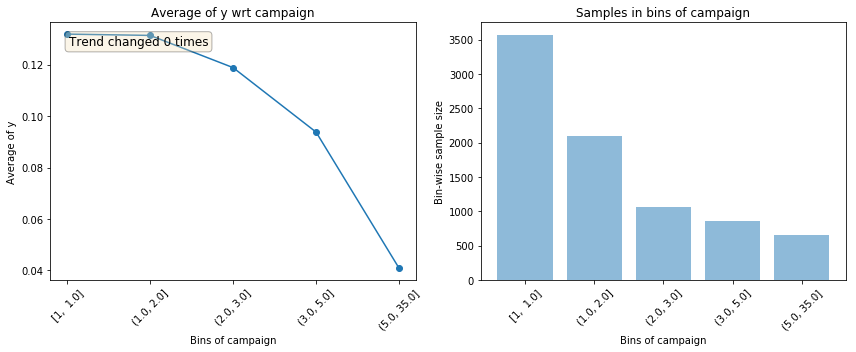

--------------------------------------------------------------------------------------------------------------


                                           Plots for pdays                                            


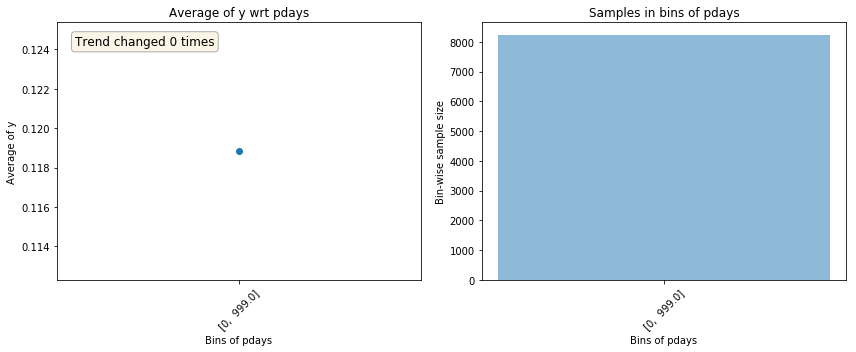

--------------------------------------------------------------------------------------------------------------


                                          Plots for previous                                          


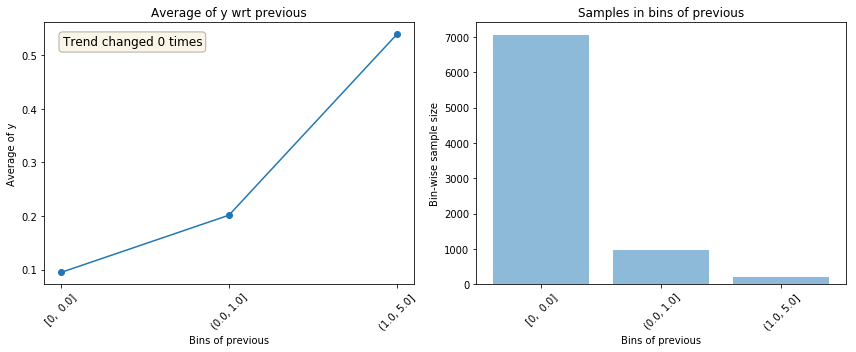

--------------------------------------------------------------------------------------------------------------


poutcome is categorical. Categorical features not supported yet.
                                        Plots for emp.var.rate                                        


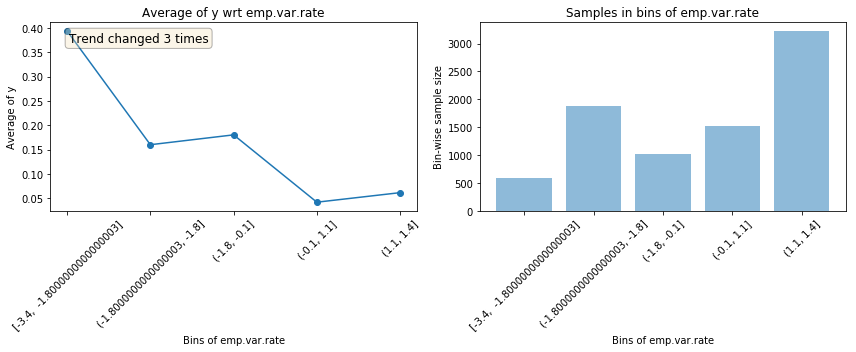

--------------------------------------------------------------------------------------------------------------


                                       Plots for cons.price.idx                                       


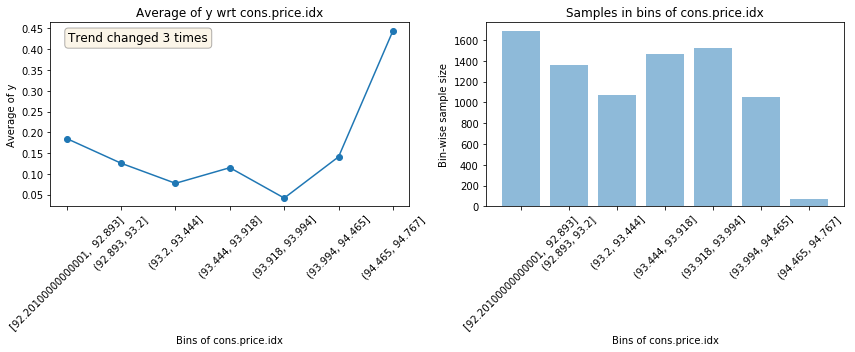

--------------------------------------------------------------------------------------------------------------


                                       Plots for cons.conf.idx                                        


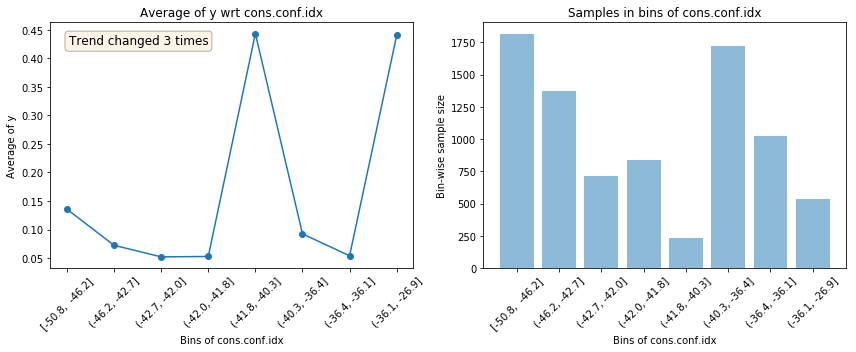

--------------------------------------------------------------------------------------------------------------


                                         Plots for euribor3m                                          


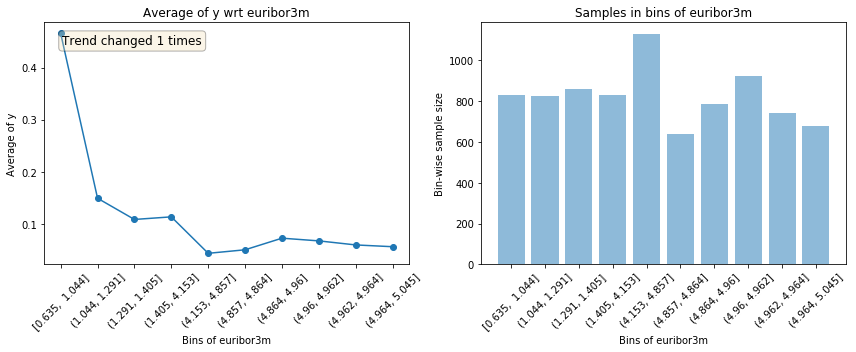

--------------------------------------------------------------------------------------------------------------


                                        Plots for nr.employed                                         


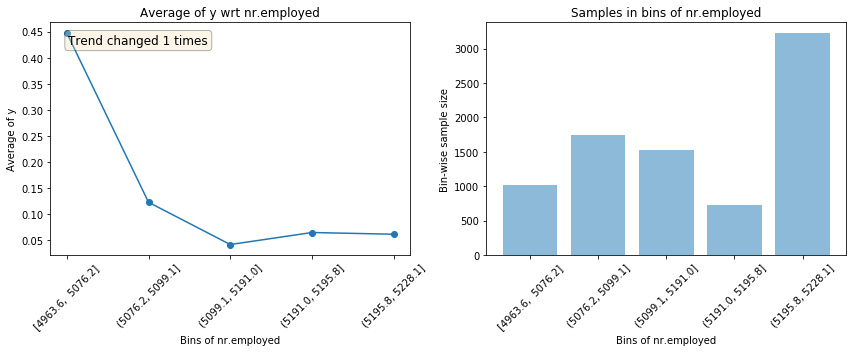

--------------------------------------------------------------------------------------------------------------




In [37]:
%autoreload 2
from visualization.visualize import *

# FeatExp
featexp_plots(sample_train=sample_train)


                                            Plots for age                                             


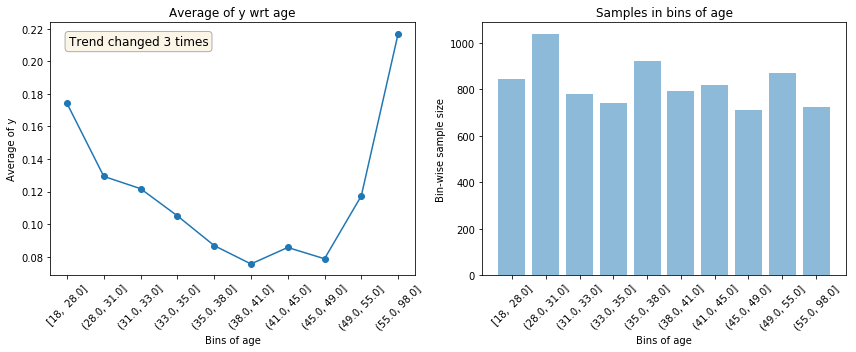

--------------------------------------------------------------------------------------------------------------


                                          Plots for campaign                                          


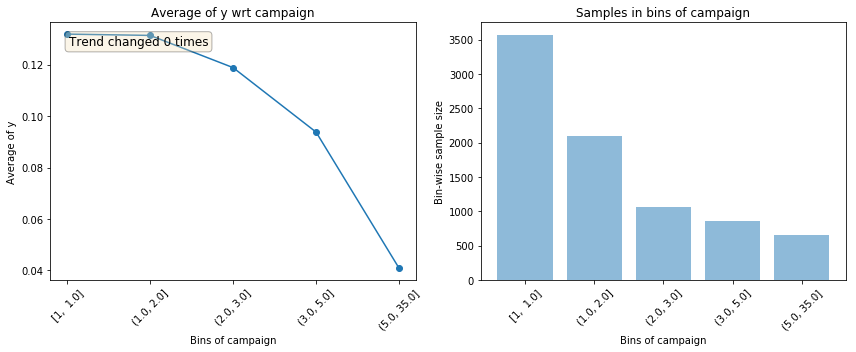

--------------------------------------------------------------------------------------------------------------


                                           Plots for pdays                                            


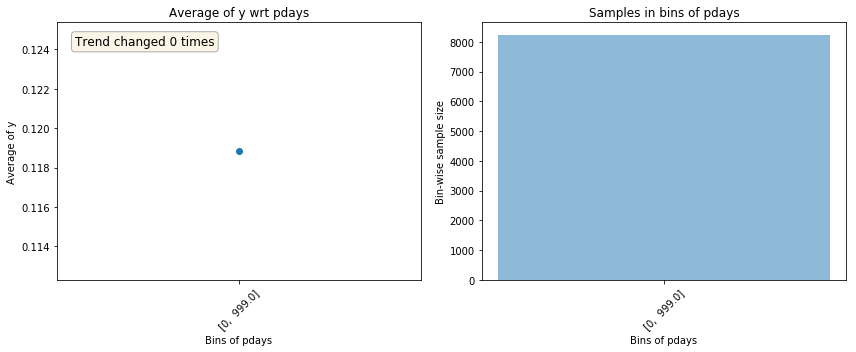

--------------------------------------------------------------------------------------------------------------


                                          Plots for previous                                          


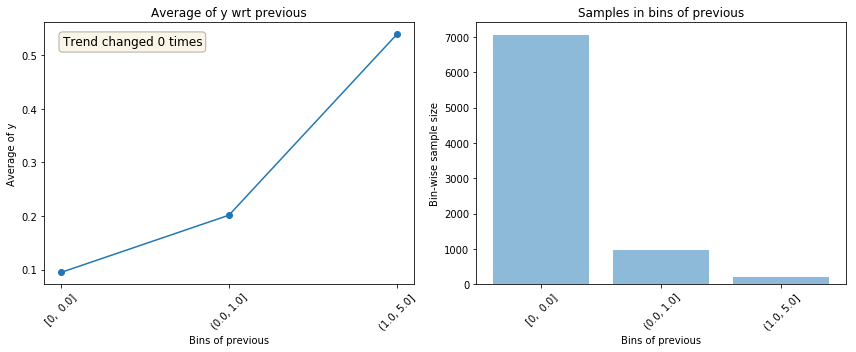

--------------------------------------------------------------------------------------------------------------


                                        Plots for emp.var.rate                                        


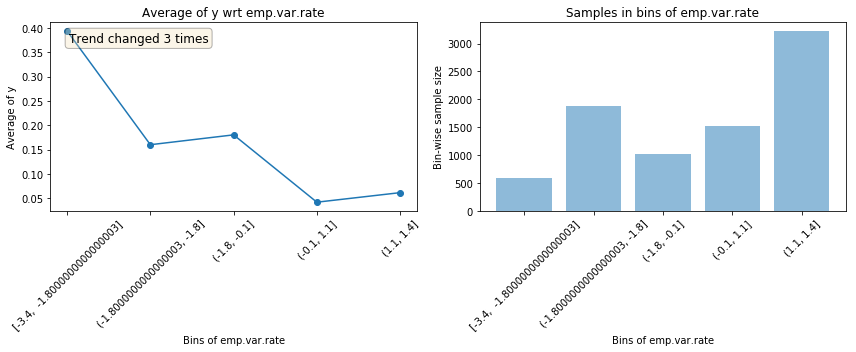

--------------------------------------------------------------------------------------------------------------


                                       Plots for cons.price.idx                                       


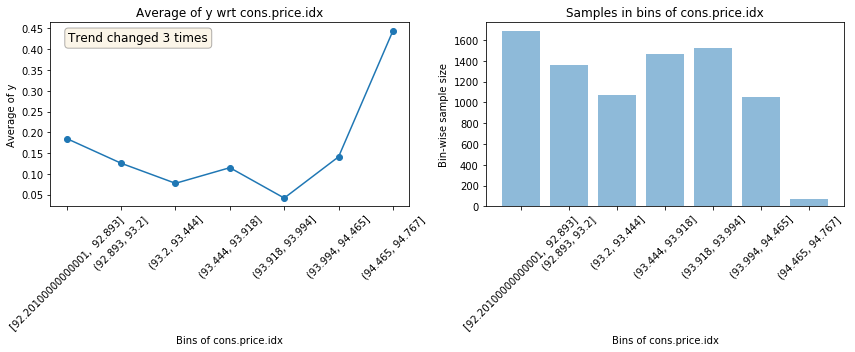

--------------------------------------------------------------------------------------------------------------




IndexError: ('index 7 is out of bounds for axis 1 with size 7', 'occurred at index cons.price.idx')

In [71]:
%autoreload 2
from features.build_features import *

# Histograms
get_scaler_columns(sample_train=sample_train)


In [75]:
temp.apply(lambda x: x)

,cons.price.idx
28560,1
13451,3
4243,4
25547,1
27072,1
4006,4
21292,2
27956,0
32253,0
32835,0
